In [25]:
import matplotlib.pyplot as plt
from Funciones import *

Esta sección tiene el proposito de hacer una inspección descriptiva de una serie temporal y, <br>
posteriormente, los primeros modelo predictivos basados en suavizado exponencial. <br>
<br>
Esquema de trabajo<br>
<br> 
1. Leer valores
2. Representar la serie
3. Descomposicion de la serie y contraste de estacionariedad
4. Creación de partición en ventanas training/test
5. Aplicación de modelos de suavizado y evaluación de ajuste
<br>
Con esto tendremos una primera aproximación para la predicción de datos a futuro <br>
en una serie temporal univariante.

In [48]:
datos = pd.read_csv("AirPassengers.csv")
fechas = pd.date_range("1949-01-01", "1960-12-01", freq="MS").strftime("%Y-%m")
fechas = pd.Series(fechas)
datos = pd.concat([fechas, datos], axis=1)
datos = datos.set_index(["Month"])
datos.index = pd.to_datetime(datos.index)
datos = datos.drop(columns=[0])

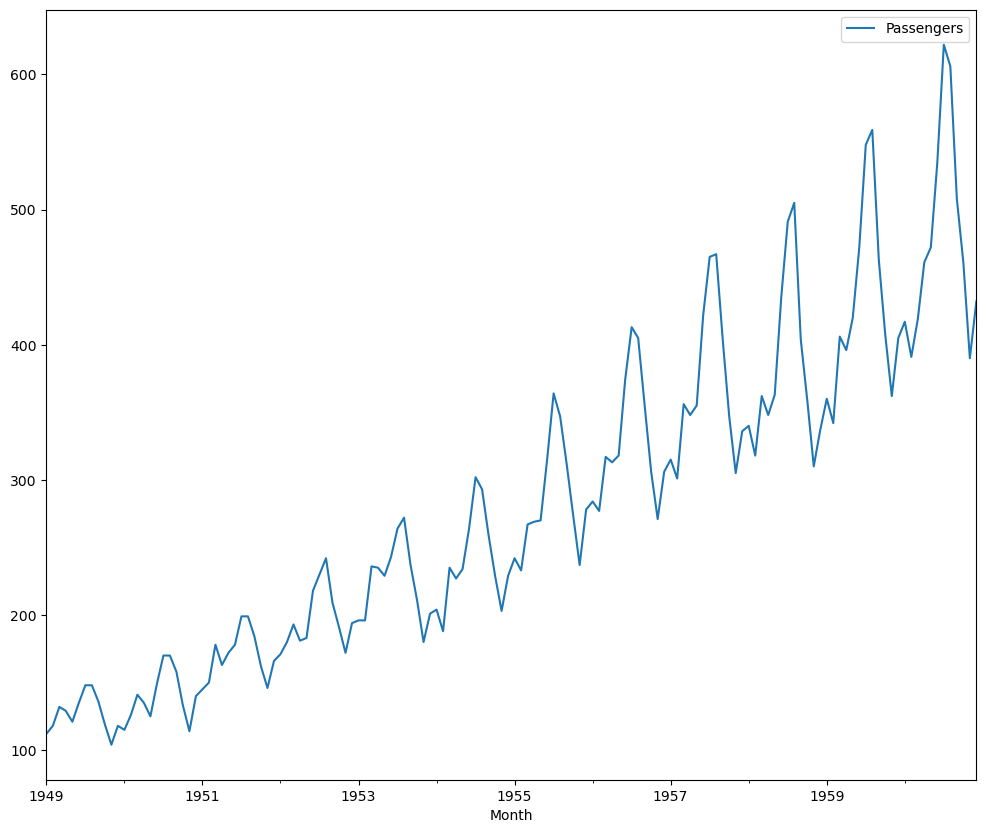

In [49]:
plt.rcParams["figure.figsize"] = (12, 10)
datos.plot()
plt.show()

Dickey Fuller

In [50]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(datos)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Descomposicion de la serie
En base a la descomposición descriptiva por medias móviles, se extraen los componentes de tendencia <br>
y estacionalidad

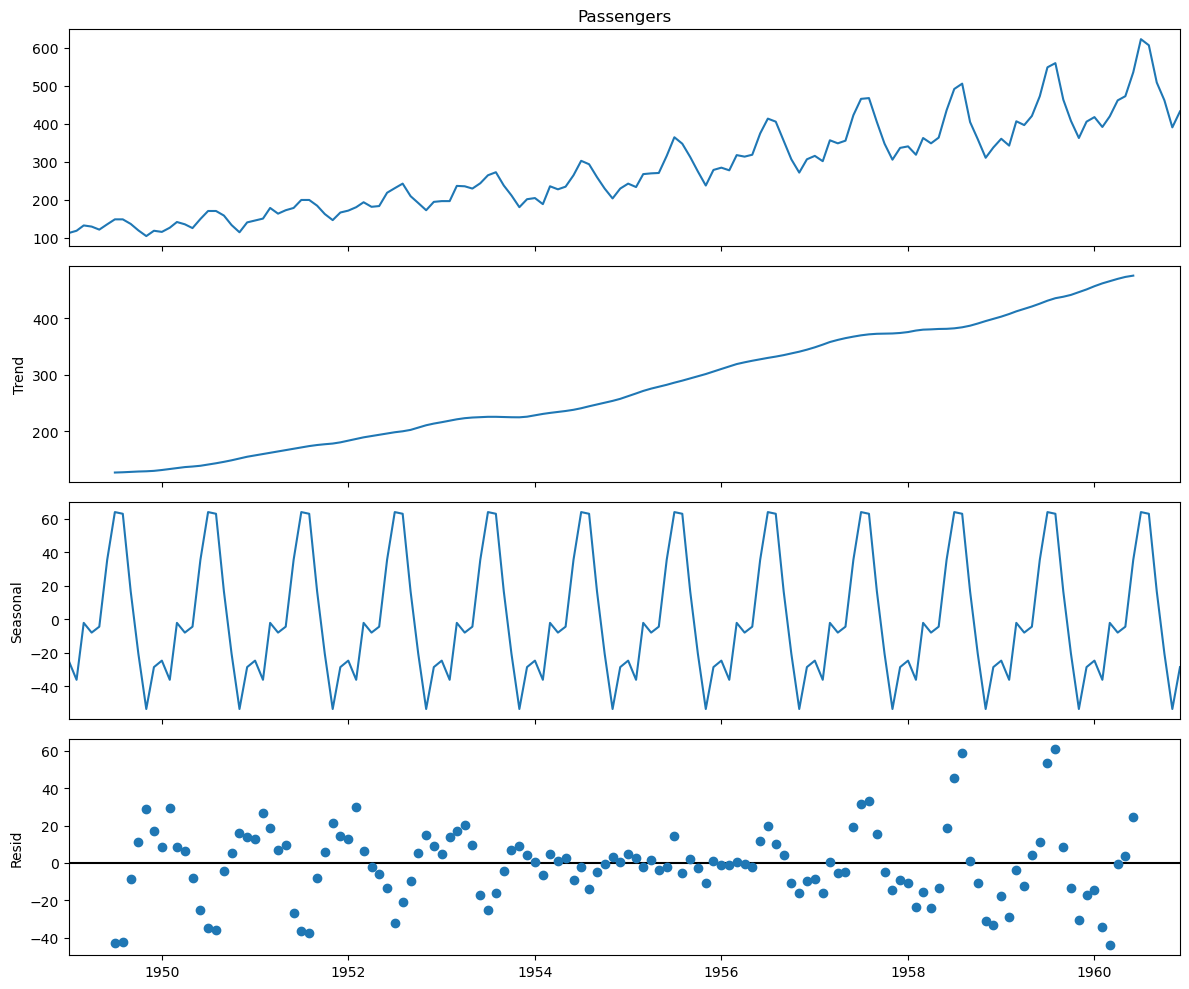

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
descomposicion_aditiva = seasonal_decompose(datos["Passengers"], model="additive", period=12)
descomposicion_aditiva.plot()
plt.show()

Evaluamos estacionariedad de los residuos de la descomposición aditiva. Aquí, debido a que la tendencia <br>
se calcula por medias móviles, los primeros y últimos valores de la serie son NA, no se calculan. <br>
Tener esto en cuenta.

In [52]:
test_stationarity(descomposicion_aditiva.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -5.298428
p-value                          0.000006
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


### Descomposición Multiplicativa

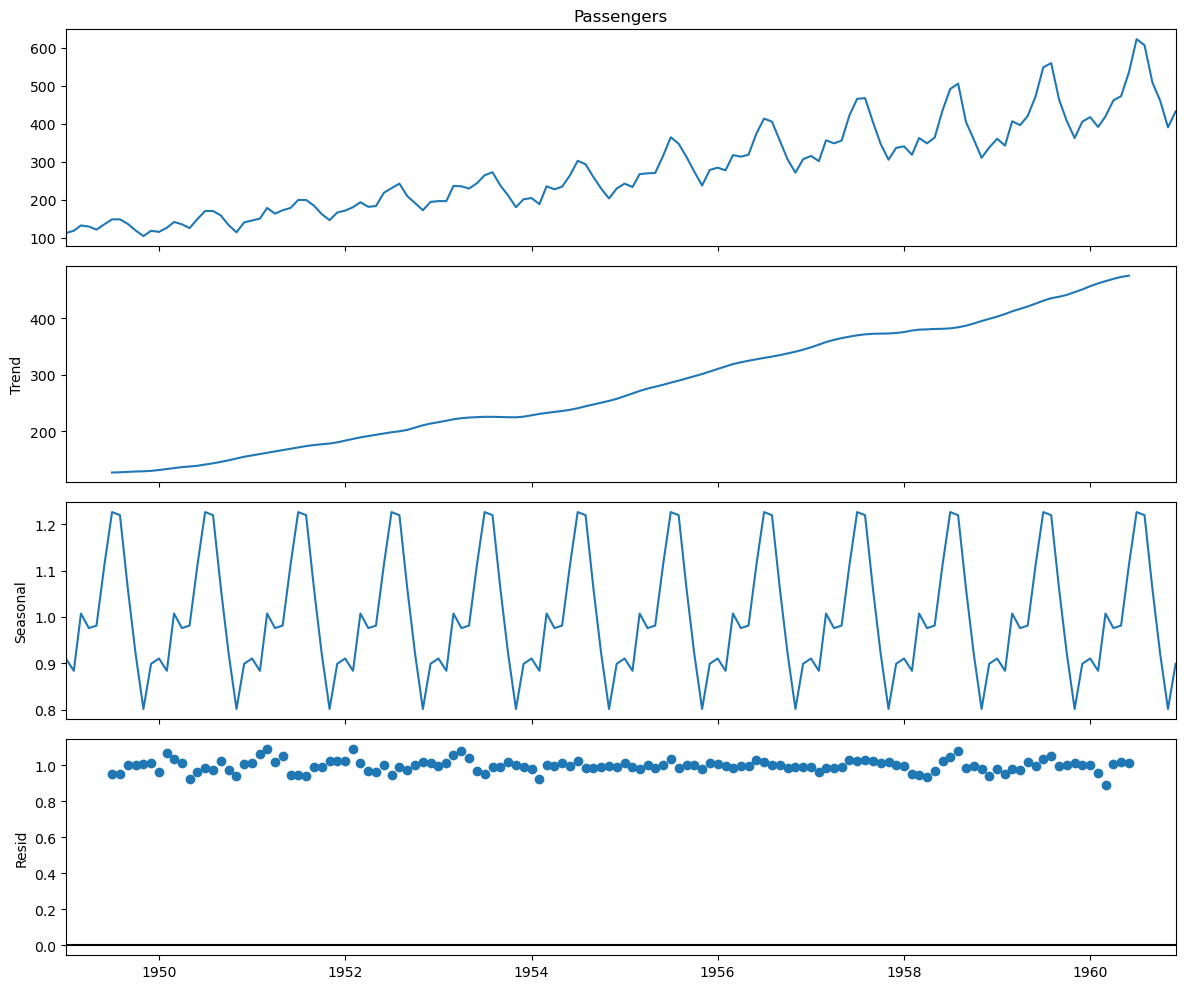

In [53]:
descomposicion_multiplicativa = seasonal_decompose(datos["Passengers"], model='multiplicative', period=12)
descomposicion_multiplicativa.plot()
plt.show()

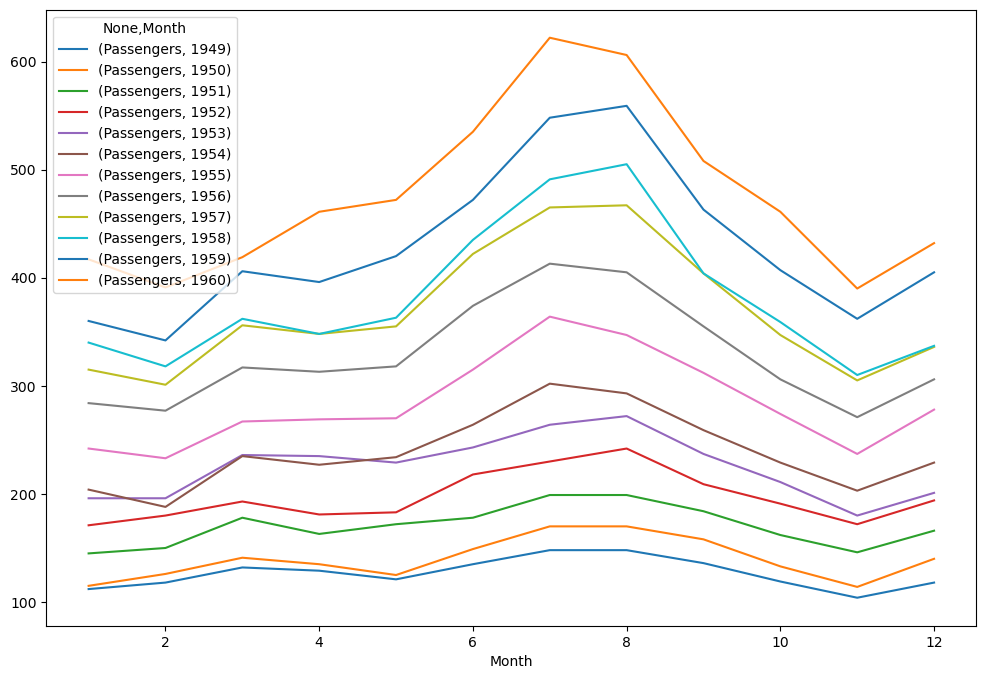

In [54]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))

seasonal_plot(datos)
plt.show()

En esta sección vamos a extraer los componentes identificados para generar una serie residual y comprobar <br>
si es estacionaria una vez eliminados los efectos típicos de las series temporales. <br>
<br>

1. Estabilización de la varianza (Transformación Logaritmica)
2. Diferenciación regular
3. Diferenciación estacional
<br>
Con la serie resultante, comprobaremos estacionariedad y será con la que podemos valorar autocorrelaciones <br>
simple y parciales para proponer órdenes ARIMA tentativos para la serie.

In [59]:
datos["Logaritmo"] = np.log(datos)
datos.head(5)

,Passengers,Logaritmo
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


La mayoría de los modelos de series temporales, incluyendo ARIMA, asumen que la serie tiene una varianza <br>
constante o homocedastica. <br>
<br>
El racional detrás de tomar el logaritmo de una serie temporal para estabilizar la varianza es el siguiente: <br>
<br>
- Reducción de la Heterocedasticidad: Si la serie temporal muestra heterocedasticidad, donde la variabilidad <br>
de la serie aumenta o disminuye con el nivel de la serie, la transformación logarítmica puede ayudar a <br>
reducir este efecto, ya que el logaritmo es una transformación no lineal que afecta más a los valores grandes <br> 
que a los pequeños.
<br>
<br>
>
###  Heterocedasticidad 
>
>Si en una parte de la serie temporal los valores fluctúan suavemente alrededor de la media (es decir, <br>
las diferencias entre los valores de la serie y su media son pequeñas), y en otra parte las fluctuaciones <br>
son mucho mayores (las diferencias son grandes), entonces la serie presente variabilidad no constante o <br>
Heterocedasticidad.
<br>
<br>
En contextos prácticos, la heterocedasticidad en una serie temporal podría observarse como una expansión en <br>
la amplitud de las fluctuaciones conforme aumenta el valor de la serie.
>
- Relaciones Multiplicativas a Aditivas: La transformación logarítmica convierte relaciones multiplicativas <br>
en aditivias, lo que puede simplificar el patrón de la serie temporal y hacer que la estructura de correlación <br>
sea más consistente a lo largo del tiempo, algo que es preferible para el modelado ARIMA.


### Diferenciación Regular

In [60]:
datos["Diferencia_1"] = datos["Passengers"].diff(periods=1)
datos.head(2)

,Passengers,Logaritmo,Diferencia_1
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,6.0


La diferenciación aborda la no estacionariedad relacionada con la tendencia y/o la <br>
estacionalidad. Al diferenciar una serie temporal, se restan valore consecutivos (o <br>
valores separados por un periodo de estacionalidad) para eliminar tendencias o patrones <br>
estacionales.

* Cúando Usarla: Si la serie temporal muestra tendencias claras (incrementos o decrementos <br>
sistemáticos a lo largo del tiempo) o estacionalidad (patrones que se repiten en intervalos <br>
regulares), la diferenciación puede ayudar a remover estos componentes, haciendo la serie más <br>
estacionaria.<br>
<br>
### Resumen
La transformación logarítmica se enfoca en la homogenización de la variabilidad, mientras que <br>
la diferenciación se centra en la eliminación de componente sistemáticos como tendencias y patrones estacionales.


### Diferenciación estacional

In [61]:
datos["Diferencia_12"] = datos["Passengers"].diff(periods=12) # periodo anual

Month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Name: Diferencia_1, Length: 143, dtype: float64

In [71]:
print("Resultados Logaritmo") 
test_stationarity(datos["Logaritmo"])
print("-----")
print("Resultados Diferenciacion mensual")
test_stationarity(datos["Diferencia_1"].dropna())
print("-----")
print("Resultados Diferenciacion Anual")
test_stationarity(datos["Diferencia_12"].dropna())

Resultados Logaritmo
Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
-----
Resultados Diferenciacion mensual
Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
-----
Resultados Diferenciacion Anual
Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)   

Tomando en cuenta estos resultados parece que unicamente la diferenciación anual convierte <br>
la serie estacional en estacionaria.

## Autocorrelaciones

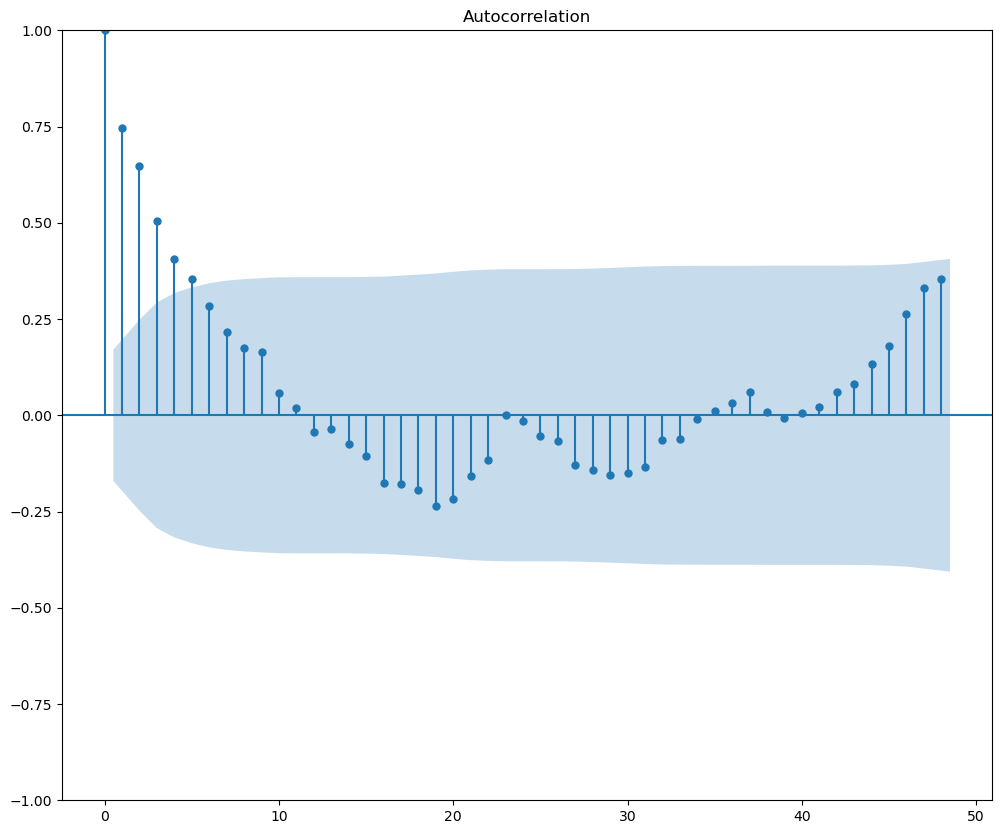

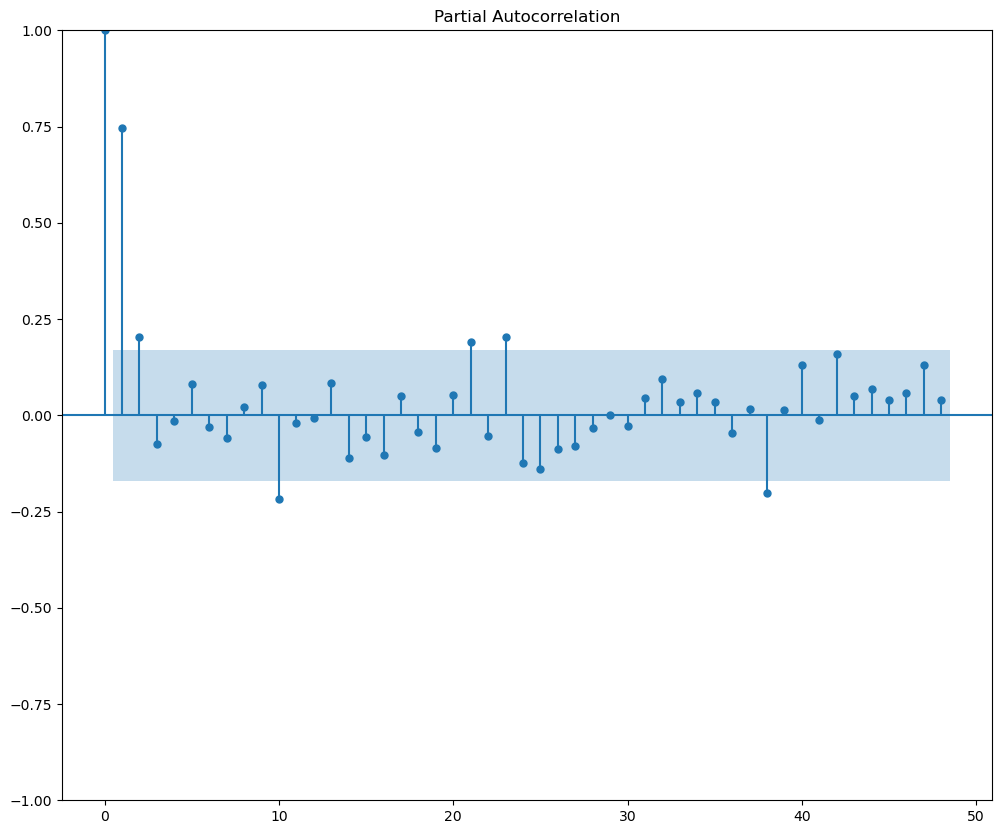

In [84]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(datos["Diferencia_12"].dropna(), lags=48)
plt.show()
plot_pacf(datos["Diferencia_12"].dropna(), lags=48)
plt.show()

Se observa que para el termino autorregresivo es signficativo hasta el 3 lag <br>
Para el promedio movil es signficativo hasta el disparo 5. <br>

In [ ]:
# P =3
# D = 1
# Q = 5


### Aplicaciones principales del test Ljung-Box
- 1. Validacion de Modelos de Series Temporales: Después de ajustar un modelo ARIMA, <br>
se utiliza para verificar si el modelo ha capturado toda la autocorrelación y si los <br>
residuos son ruido blanco (es decir, independientes y normalmente distribuidos). 
- 2. Diagnóstico de la Adecuación del Modelo: Si el test resulta en rechazar la hipótesis <br>
nula, esto sugiere que el modelo no ha capturado completamente la estructura de dependencia en los datos <br>
y podrían ser necesario terminos adicionales en el modelo.

In [88]:
sm.stats.acorr_ljungbox(datos["Diferencia_12"].dropna(), lags=10, return_df=True)

,lb_stat,lb_pvalue
1,75.235169,4.178574e-18
2,132.206392,1.957702e-29
3,167.159543,5.222124e-36
4,189.989479,5.327902e-40
5,207.520093,6.986450e-43
6,218.793090,1.881919e-44
7,225.412006,4.681125e-45
8,229.781785,3.293166e-45
9,233.684182,2.755306e-45
10,234.158558,1.152890e-44
